# Олимпиада по Кибериммунной разработке  

## Создание конструктивно защищённой автономной роботизированной платформы бурения тоннелей  

## Модуль 1

## О документе

Общая информация и модуль 1 для олимпиады по кибериммунной разработке


## О кибериммунной разработке

Больше информации о кибериммунном подходе к разработке можно найти на [этой](https://github.com/sergey-sobolev/cyberimmune-systems/wiki/%D0%9A%D0%B8%D0%B1%D0%B5%D1%80%D0%B8%D0%BC%D0%BC%D1%83%D0%BD%D0%B8%D1%82%D0%B5%D1%82) странице 

## Сокращения

* АРПБТ - автономная роботизированная платформа бурения тоннелей

## О задаче

Автономная роботизированная платформа бурения тоннелей (АРПБТ) выполняет функцию автоматического бурения тоннелей под землей в ограниченных условиях.

Основные функции платформы:
1. Получение задания на перемещение в нужный сегмент шахты
2. Расчёт и осуществление перемещения в заданную точку с учётом ограничений в задании и текущих координат
3. Передача информации о ходе выполнения задачи 
4. Бурение тоннеля

### Архитектура бортовых информационных систем

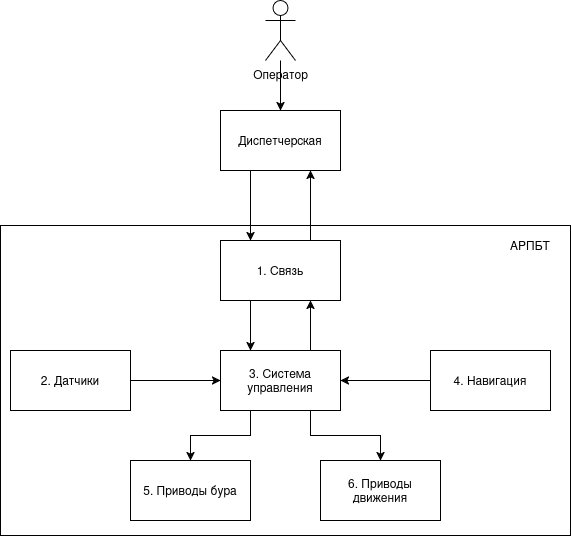

Рис. 1. Базовая упрощённая архитектура

Такая архитектура позволяет реализовать функции автономного перемещения и бурения в условиях отсутствия кибератак.

Эта же архитектура, но с указанием передаваемых между блоками данных показана на рисунке 2.

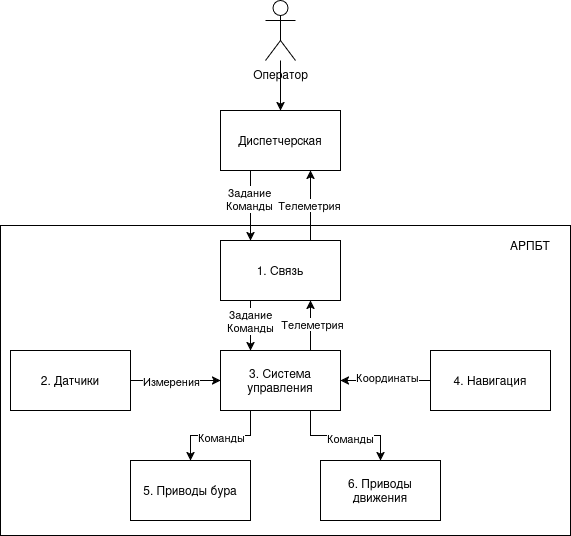

Рис. 2. Диаграмма потоков данных

Взаимодействие компонентов отражено на следующей диаграмме (рис.3). Она называется диаграммой последовательности, читать её нужно сверху вниз, по стрелкам. Каждая стрелка обозначает или запрос (сплошная) или ответ (пунктирная). Стрелки пронумерованы для удобства.

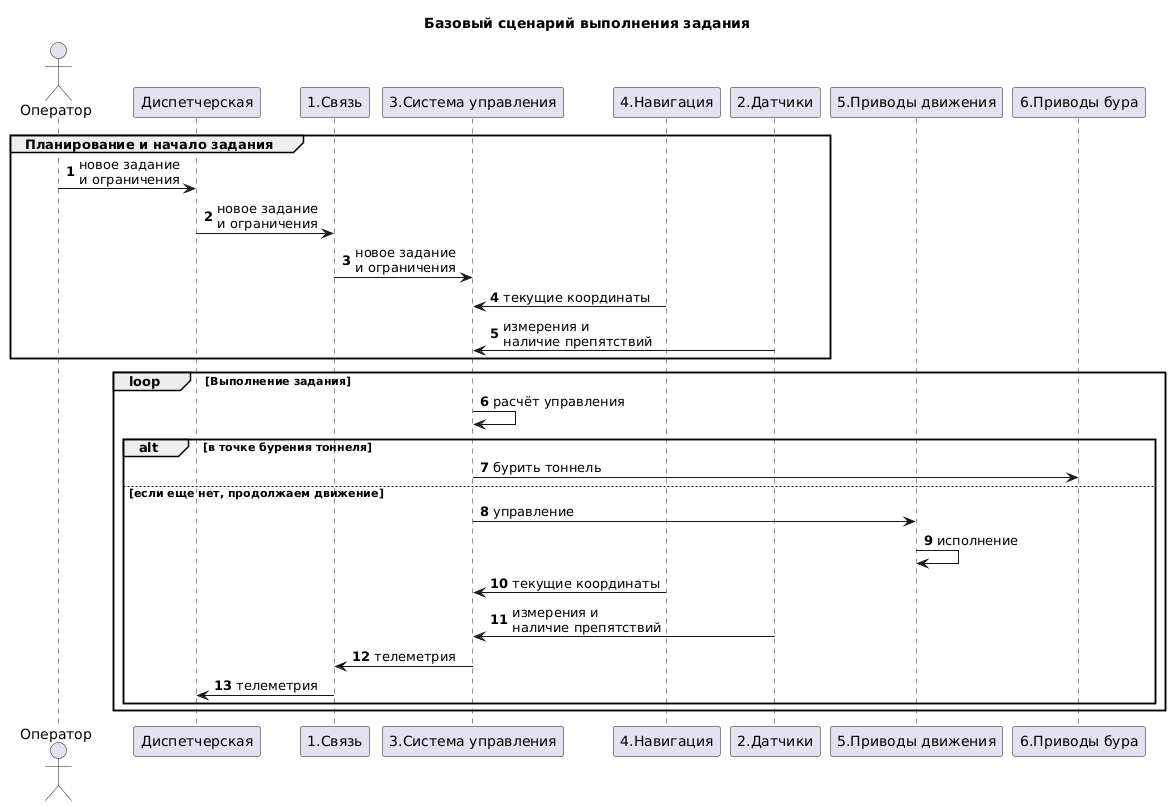

Рис. 3. Базовый сценарий

## Задания модуля 

### Сборка основных компонентов

В рамках этого модуля необходимо будет из отдельных программных компонентов (блоков) собрать модель АРПБТ. Это похоже на крупноузловую сборку автомобиля, только нашей задаче будет не крутить гайки, а настроить информационные потоки между блоками для правильной работы всей системы.

#### Решение этой задачи

1. Создадим функциональные компоненты (сущности 1, 3, 4, 5, 6), при этом каждый компонент будет работать в отдельном процессе
2. Реализуем передачу данных между компонентами
3. Взаимодействие всей системы происходит через общую очередь

Так как наша АРПБТ виртуальная, то для представления движения по шахте платформы, будет использоваться система симуляции перемещения (simulation).
На рисунке 4 представлена диаграмма потока данных с учетом симуляции.

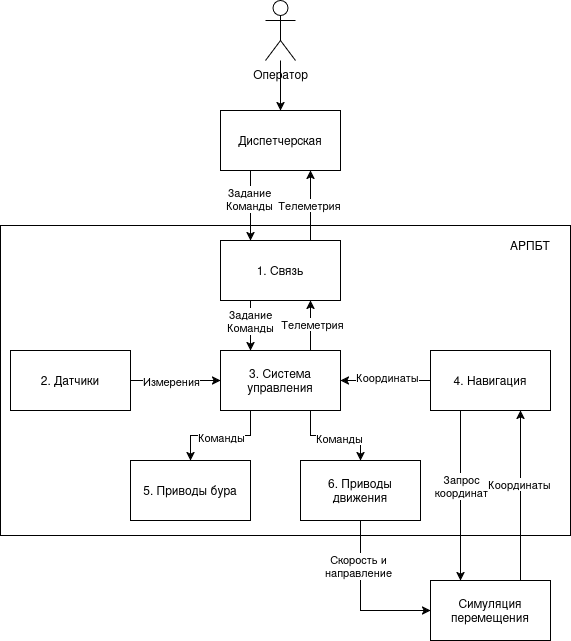

В коде назовём компоненты следующим образом

|№ в диаграмме|Название в диаграмме|Название в коде|
|:-:|:-:|:-:|
|1|Связь|Communication|
|2|Датчики|Sensors|
|3|Система управления|ControlSystem|
|4|Навигация|Navigation|
|5|Приводы буры|Drill|
|6|Приводы движения|Servos|
|7|Монитор безопасности|SecurityMonitor|

Перед запуском всей системы, необходимо настроить симулятор перемещения, для этого в консоли следует выполнить:

```bash
make dev-install

python src/simulation.py
```

или (в случае ручной установке без использования Makefile)

```bash
python -m venv .venv

.venv/bin/activate

pip install -r requirements.txt

python src/simulation.py
```

После этого зайдите в браузере (желательно использовать Chrome) и введите данную ссылку

http://127.0.0.1:5000

Вы увидите карту шахты и местоположение АРПБТ

Для реализации сущность и взаимодействия между ними будем использовать очереди

Создадим общий пул очереди

In [ ]:
from multiprocessing import Queue

events_queue = Queue()

Создадим два Класса для удобства передачи данных между сущностями

In [ ]:
from dataclasses import dataclass


# формат управляющих команд
@dataclass
class ControlEvent:
    operation: str


@dataclass
class Event:
    source: str  # отправитель
    destination: str  # получатель
    operation: str  # чего хочет (запрашиваемое действие)
    parameters: str  # с какими параметрами

Создадим общего менеджера очереди который будет направлять необходимые операции и данные между нашими функциональными блоками, в нём же будет происходить регистрация всех необходимых сущностей.

In [ ]:
from multiprocessing import Queue, Process
from multiprocessing.queues import Empty
from time import sleep


# Класс
class QueueManage(Process):

    def __init__(self, events_q: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self._events_q = events_q  # очередь событий входящие сообщения
        self._control_q = (
            Queue()
        )  # очередь управляющих команд (например, для остановки)
        self._entity_queues = {}  # словарь очередей известных сущностей
        self._force_quit = False  # флаг завершения работы

    # регистрация очереди новой сущности
    def add_entity_queue(self, entity_id: str, queue: Queue):
        print(f"[ИНФО] регистрируем сущность {entity_id}")
        self._entity_queues[entity_id] = queue

    def _proceed(self, event):
        # print(f'[ИНФО] отправляем запрос {event}')
        try:
            # найдём очередь получателя события
            dst_q: Queue = self._entity_queues[event.destination]
            # и положим запрос в эту очередь
            dst_q.put(event)
        except Exception as e:
            # например, запрос пришёл от или для неизвестной сущности
            print(f"[ИНФО] ошибка выполнения запроса {e}")

    # основной код работы монитора безопасности
    def run(self):
        print("[ИНФО] старт")

        # в цикле проверяет наличие новых событий,
        # выход из цикла по флагу _force_quit
        while self._force_quit is False:
            event = None
            try:
                # ожидание сделано неблокирующим,
                # чтобы можно было завершить работу монитора,
                # не дожидаясь нового сообщения
                event = self._events_q.get_nowait()
                self._proceed(event)
            except Empty:
                # сюда попадаем, если новых сообщений ещё нет,
                # в таком случае немного подождём
                sleep(0.5)
            except Exception as e:
                # что-то пошло не так, выведем сообщение об ошибке
                print(f"[ИНФО] ошибка обработки {e}, {event}")
            self._check_control_q()
        print("[ИНФО] завершение работы")

    # запрос на остановку для завершения работы
    # может вызываться вне процесса
    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    # проверка наличия новых управляющих команд
    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            # print(f"[ИНФО] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

#### Сущность Communication

Сущность модуля Связи в него приходят новые задания и так же он отсылает данные телеметрии в Диспетчерскую, в данном модуль реализован функционал передачи задания в Систему управления 

In [ ]:
from multiprocessing import Queue, Process


class Communication(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()

    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")
        print(f"[{self.__class__.__name__}] отправляем новое задание")

        # Отметили точку в симуляторе и скопировали её, вставили сюда
        task = 
        # запрос для сущности ControlSystem с передачей задания
        event = Event(
            source=self.__class__.__name__,
            destination="ControlSystem",
            operation="new_task",
            parameters=task,
        )

        self.events_queue.put(event)
        print(f"[{self.__class__.__name__}] завершение работы")

#### **Сущность ControlSystem**

Сущность модуля Системы управления, реализует все расчёт АРПБТ, отвечает за выполнение заданий и управляет всеми приводами.

Здесь будет необходимо ***выполнить задание модуля 1 Олимпиады***, а именно реализовать недостающий фрагмент кода для того чтобы АРПБТ смог пробурить тоннель в авторизованном пункте назначения (контрольная точка), **во время движения бурить нельзя**, может обрушиться тоннель. Реализуйте функцию **send_to_drill** и так же связь между **ControlSystem** и **Servos** (подсказка! Необходимо добавить отправку параметров скорости и направления в ControlSystem)

Для тестирования симуляции поставить Контрольную точку (синий цвет точки) на прямой от АРПБТ и проверьте происходит ли остановка и бурение в заданной точке. Не забудьте сохранить точку в Communication.

Подсказка:

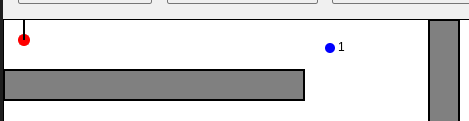

In [ ]:
from multiprocessing import Queue, Process
from src.control_systems_calc import update_speed_and_direction


class ControlSystem(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()
        self._control_q = (
            Queue()
        )  # очередь управляющих команд (например, для остановки)
        self._force_quit = False
        self._targets_points = []  # Точки маршрута
        self._current_coordinates = None  # Текущие координаты АРПБТ
        self._current_speed = 30  # Скорость АРПБТ
        self._current_direction = 90  # Базовое направление движения АРПБТ в градусах
        self._obstacle_distances = (
            []
        )  # Массив расстояний до препятствий по 6 направлениям
        self._status = (
            ""  # Статус АРПБТ, находится в движении или достигла точки маршрута
        )
        self._counter = 1  # Счётчик пройденных точек маршрута
        self.max_speed = 30

    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    def control_entity_queue(self):
        return self._control_q

    def send_to_drill(self):
        event = None
    
    def mission_move(self):
        if (
                self._current_coordinates and self._obstacle_distances is not None
            ):  # Проверка первичной инициализации АРПБТ
                if len(self._targets_points) > 0:
                    target_point = self._targets_points[0]
                    self._current_speed, self._current_direction, self._status = (
                        update_speed_and_direction(
                            (
                                self._current_coordinates["x"],
                                self._current_coordinates["y"],
                            ),
                            (target_point["x"], target_point["y"]),
                            self._current_speed,
                            self._current_direction,
                            self._obstacle_distances,
                            self.max_speed,
                        )
                    )

                    if self._status == "success":
                        if target_point["type"] == "checkpoint":

                            print(
                                f"[{self.__class__.__name__}] точка бурения {self._counter} достигнута"
                            )

                            self.send_to_drill()

                            self._status = ""
                            self._counter += 1
                            self._targets_points.pop(0)

                    data = {
                        "speed": ,
                        "direction": ,
                    }

                    # print(f'[{self.__class__.__name__}] отправляем сигналы управления приводами движения {json.dumps(data)}')

                    event = Event(
                        source=self.__class__.__name__,
                        destination="Servos",
                        operation="",
                        parameters=data,
                    )
                    self.events_queue.put(event)

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")
        while self._force_quit is False:
            sleep(0.02)
            event = None
            self._check_event_queue()
            self._check_control_q()
            self.mission_move()

        print(f"[{self.__class__.__name__}] завершение работы")

    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

    def _check_event_queue(self):
        event = None
        try:
            event: Event = self._own_queue.get_nowait()

            if event.operation == "new_task":
                print(
                    f"[{self.__class__.__name__}] {event.source} прислал новое задание {event.parameters}"
                )
                print(f"[{self.__class__.__name__}] новое задание: {event.parameters}!")
                self._targets_points = event.parameters

            if event.operation == "get_coordinates":
                # print(f"[{self.__class__.__name__}] текущая позиция АРПБТ {event.parameters}")
                self._current_coordinates = event.parameters

            # if event.operation == "get_directions":
            # print(f"[{self.__class__.__name__}] текущие измерения расстояний до препятствий АРПБТ {event.parameters}")
            #    self._obstacle_distances = event.parameters

        except Empty:
            sleep(0.05)
        except Exception as e:
            # что-то пошло не так, выведем сообщение об ошибке
            print(f"[{self.__class__.__name__}] ошибка обработки {e}, {event}")

#### Сущность Navigation

Запрашивает текущие координаты АРПБТ и передает их в Систему управления

In [ ]:
import requests
from multiprocessing import Queue, Process


class Navigation(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()
        self._control_q = Queue()
        self._force_quit = False

    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    def control_entity_queue(self):
        return self._control_q

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")
        while self._force_quit is False:
            try:
                sleep(0.05)
                response = requests.get(
                    "http://127.0.0.1:5000/position"
                )  # URL для получения текущих координат
                response.raise_for_status()
                coordinates = response.json()
                # print(f"[{self.__class__.__name__}]Текущая позиция: X={coordinates['x']}, Y={coordinates['y']}")
                event = Event(
                    source=self.__class__.__name__,
                    destination="ControlSystem",
                    operation="get_coordinates",
                    parameters=coordinates,
                )
                self.events_queue.put(event)
                self._check_control_q()
            except requests.exceptions.RequestException as e:
                print(f"[{self.__class__.__name__}]Ошибка запроса: {e}")
                self._check_control_q()

        print(f"[{self.__class__.__name__}] завершение работы")

    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

#### Сущность Servos

Осуществляют перемещение АРПБТ, исполняют команды от Системы управления

In [ ]:
from multiprocessing import Queue, Process


class Servos(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()
        self._control_q = Queue()
        self._force_quit = False

    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    def control_entity_queue(self):
        return self._control_q

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")
        while self._force_quit is False:
            self._check_event_queue()
            self._check_control_q()

        print(f"[{self.__class__.__name__}] завершение работы")

    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    def _check_event_queue(self):
        event = None
        try:
            event: Event = self._own_queue.get_nowait()
            if event.operation == "set_velocity":
                # print(f"[{self.__class__.__name__}] {event.source} прислал новые параметры управления {event.parameters}")
                try:
                    data = event.parameters
                    response = requests.post(
                        "http://127.0.0.1:5000/set_velocity", json=data
                    )  # URL для обновления параметров скорости и направления движения
                    response.raise_for_status()
                except requests.exceptions.RequestException as e:
                    print(f"[{self.__class__.__name__}]Ошибка запроса: {e}")
        except Empty:
            sleep(0.05)
        except Exception as e:
            # что-то пошло не так, выведем сообщение об ошибке
            print(f"[{self.__class__.__name__}] ошибка обработки {e}, {event}")

    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

#### Сущность Drill

Осуществляет бурение тоннеля

In [ ]:
from multiprocessing import Queue, Process


class Drill(Process):

    def __init__(self, events_queue: Queue):
        # вызываем конструктор базового класса
        super().__init__()
        self.events_queue = events_queue
        self._own_queue = Queue()
        self._control_q = Queue()
        self._force_quit = False

    # выдаёт собственную очередь для взаимодействия
    def entity_queue(self):
        return self._own_queue

    def control_entity_queue(self):
        return self._control_q

    # основной код сущности
    def run(self):
        print(f"[{self.__class__.__name__}] старт")

        while self._force_quit is False:
            self._check_event_queue()
            self._check_control_q()

        print(f"[{self.__class__.__name__}] завершение работы")

    def stop(self):
        # поскольку работает в отдельном процессе,
        # запрос помещается в очередь, которая проверяется из процесса
        request = ControlEvent(operation="stop")
        self._control_q.put(request)

    def _check_event_queue(self):
        event = None
        try:
            event: Event = self._own_queue.get_nowait()
            if event.operation == "drilling":
                print(f"[{self.__class__.__name__}] бурим тоннель")
        except Empty:
            sleep(0.1)
        except Exception as e:
            # что-то пошло не так, выведем сообщение об ошибке
            print(f"[{self.__class__.__name__}] ошибка обработки {e}, {event}")

    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            print(f"[{self.__class__.__name__}] проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == "stop":
                # поступил запрос на остановку, поднимаем "красный флаг"
                self._force_quit = True
        except Empty:
            # никаких команд не поступило
            pass

Ниже представлен код в котором мы первично инициализируем наши модули. Необходимо для дальнейшей работы очереди

In [ ]:
queue_manager = QueueManage(events_queue)
communication = Communication(events_queue)
control_system = ControlSystem(events_queue)
navigation = Navigation(events_queue)
servos = Servos(events_queue)
drill = Drill(events_queue)

Добавляем в общую очередь все реализованные сущности, можно сказать регистрируем их в менеджере Очереди

In [ ]:
queue_manager.add_entity_queue(
    communication.__class__.__name__, communication.entity_queue()
)
queue_manager.add_entity_queue(
    control_system.__class__.__name__, control_system.entity_queue()
)
queue_manager.add_entity_queue(navigation.__class__.__name__, navigation.entity_queue())
queue_manager.add_entity_queue(servos.__class__.__name__, servos.entity_queue())
queue_manager.add_entity_queue(drill.__class__.__name__, drill.entity_queue())

Здесь происходит запуск всей системы, после запуска ждем 140 секунд для выполнения задания и потом отключаем систему.

In [ ]:
queue_manager.start()
communication.start()
control_system.start()
navigation.start()
servos.start()
drill.start()
sleep(
    120
)  # Общее время работы системы, по необходимости меняется в большую или меньшую сторону
queue_manager.stop()
communication.join()
control_system.stop()
navigation.stop()
servos.stop()
drill.stop()

Если в логе выполнения симуляции вы увидели ***[Drill] бурим тоннель*** и машинка не бурит во время движения, то переходите к 2 модулю олимпиады. Не забудьте сохранить все изменения.